# **Importation des bibliothèques**

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score,classification_report, f1_score, roc_curve, auc, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
import collections
from pprint import pprint
from time import time  # Correct
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

**Chargement des données et sélection des colonnes nécessaires pour atteindre l'objectif du projet**

In [ ]:
# Charger les données dans un DataFrame
df = pd.read_csv("/content/Tweets.csv")  # Exemple de lecture

In [ ]:
#afficher quelque lignes de la base de données
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# Supprimer les lignes où 'airline_sentiment_confidence' est inférieur à 0.5
df = df[df['airline_sentiment_confidence'] >= 0.5]
df.shape

(14404, 15)

In [ ]:
# Conserver uniquement les colonnes nécessaires
colonnes_a_garder = ['text', 'airline_sentiment']
df = df[colonnes_a_garder]

# Afficher le DataFrame mis à jour
df.columns

Index(['text', 'airline_sentiment'], dtype='object')

**Analyse et prétraitement des données**

<ipython-input-6-cd7013f2dcd1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(
<ipython-input-6-cd7013f2dcd1>:3: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.catplot(


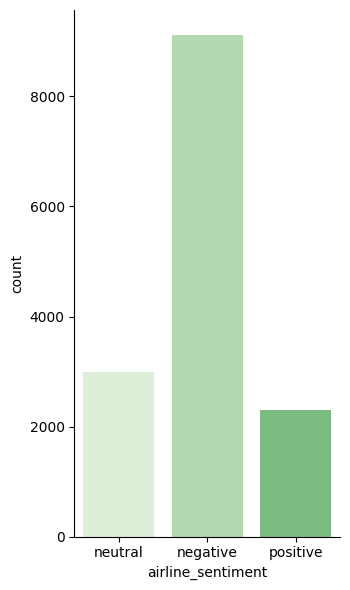

In [ ]:
# Analyse du nombre d'exemples répartis dans chaque catégories
light_green_palette = sns.color_palette("Greens", n_colors=5)
sns.catplot(
    x="airline_sentiment",
    data=df,
    kind="count",
    height=6,
    aspect=0.6,
     palette=light_green_palette      # Palette de couleurs (du clair au foncé dans des tons verts/bleus)
)
plt.show()                  # Affiche le graphique

In [ ]:
#Analyse nombre de mots, hashtag ,url... par chaque tweet
class TextCounts(BaseEstimator, TransformerMixin):

    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))

    def fit(self, X, y=None, **fit_params):
        # La méthode fit est utilisée quand des opérations spécifiques doivent être faites sur les données d'entraînement
        return self

    def transform(self, X, **transform_params):
        # Calcul des différentes caractéristiques textuelles
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x))  # Nombre de mots
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))  # Nombre de mentions
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))  # Nombre de hashtags
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))  # Nombre de mots en majuscules
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))  # Nombre de "!" ou "?"
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))  # Nombre d'URLs

        # Création du DataFrame avec les nouvelles caractéristiques
        df = pd.DataFrame({'count_words': count_words,
                           'count_mentions': count_mentions,
                           'count_hashtags': count_hashtags,
                           'count_capital_words': count_capital_words,
                           'count_excl_quest_marks': count_excl_quest_marks,
                           'count_urls': count_urls
                          })

        return df

# Application de la transformation
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
df_eda['airline_sentiment'] = df.airline_sentiment

In [ ]:
df_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,airline_sentiment
0,4,2,0,0,0,0,neutral
2,13,1,0,0,1,0,neutral
3,18,1,0,0,0,0,negative
4,11,1,0,0,0,0,negative
5,25,1,0,1,0,0,negative


In [ ]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())

    # Créer des "bins" pour l'histogramme
    bins = np.arange(df[col].min(), df[col].max() + 1)

    # Utiliser `height` au lieu de `size`
    g = sns.FacetGrid(df, col='airline_sentiment', height=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.histplot, col, kde=False, stat='probability', bins=bins)

    plt.show()

Descriptive stats for count_words
---------------------------------
                    count       mean       std  min   25%   50%   75%   max
airline_sentiment                                                          
negative           9115.0  20.409435  6.091811  2.0  17.0  22.0  25.0  35.0
neutral            2997.0  15.290624  7.144369  2.0  10.0  15.0  21.0  34.0
positive           2292.0  14.430628  7.255154  2.0   8.0  14.0  21.0  33.0


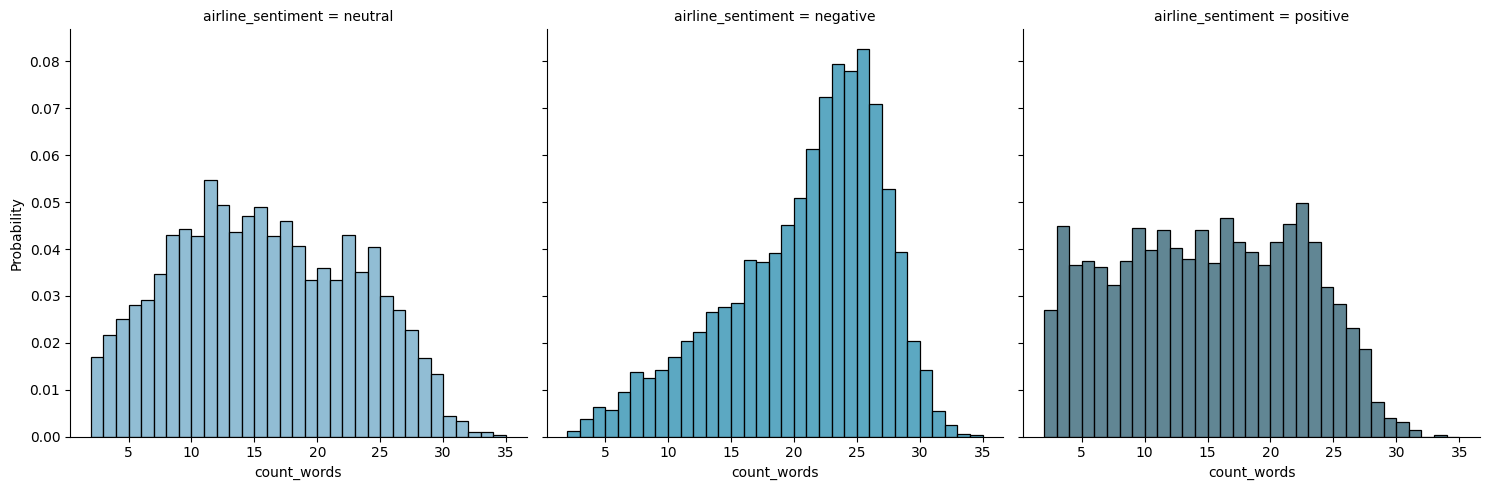

In [ ]:
show_dist(df_eda, 'count_words')

In [ ]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=6a9c92d8cd8dfdcde5225d798c7710e9517959b2ff5bee7fc13029de3496d546
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


<ipython-input-12-bfb87aaf51b4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='language', palette="Set2")


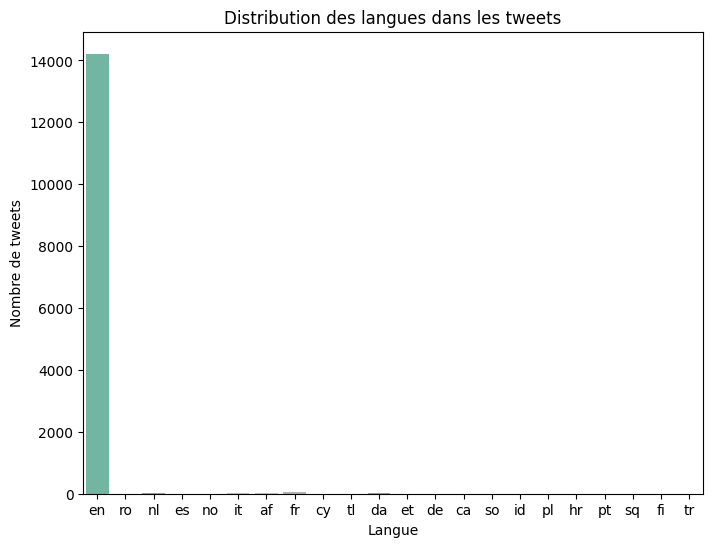

In [ ]:
from langdetect import detect

# Appliquer langdetect pour détecter la langue de chaque tweet
df['language'] = df['text'].apply(lambda x: detect(x))

# Afficher la distribution des langues
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='language', palette="Set2")
plt.title('Distribution des langues dans les tweets')
plt.xlabel('Langue')
plt.ylabel('Nombre de tweets')
plt.show()


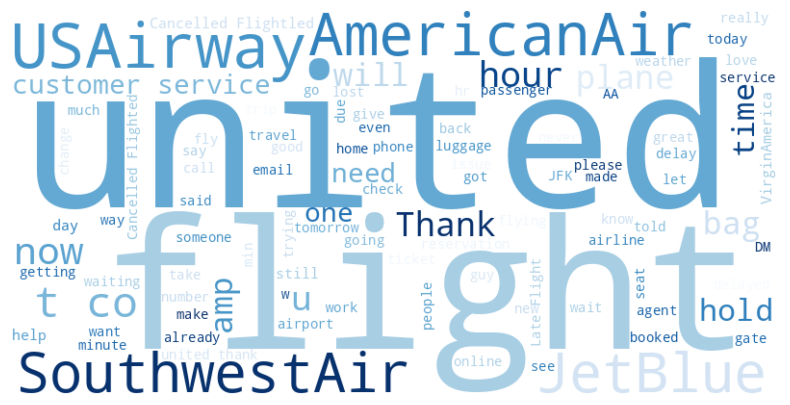

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Récupérer le texte des tweets (par exemple, la colonne 'text' dans ton DataFrame)
text = ' '.join(df['text'].dropna())  # Combine tous les tweets en une seule chaîne

# Créer le nuage de mots
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Blues',  # Choisir une palette de couleurs
    max_words=100,  # Limiter le nombre de mots affichés
    stopwords=None  # Optionnel, si tu veux ajouter des mots à ignorer (par exemple des mots vides)
).generate(text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ne pas afficher les axes
plt.show()

In [88]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.6 MB/s eta 0:00:00


In [110]:
from nltk.stem import WordNetLemmatizer
import emoji

class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)

    def remove_emoji(self, input_text):
        return emoji.replace_emoji(input_text, replace='')

    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

    def emoji_oneword(self, input_text):
        return input_text.replace('_','')

    def remove_punctuation(self, input_text):
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)

    def to_lower(self, input_text):
        return input_text.lower()

    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        whitelist = ["n't", "not", "no", "i'm"]
        words = input_text.split()
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
        return " ".join(clean_words)

    def lemmatization(self, input_text):
        lemmatizer = WordNetLemmatizer()
        words = input_text.split()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(lemmatized_words)

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_emoji).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.lemmatization)
        return clean_X

In [111]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [112]:
# Créer une instance de la classe CleanText
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

,text
6928,listen im not gonna deny rt fleet fleek
2624,not reason houston not nyc tonight took plane ...
3091,access dial make faster
6045,delay flight bdl mco need get florida amp race...
11486,way someone contact agent available need help ...


In [113]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))

21 records have no words left after text cleaning


In [114]:
sr_clean = sr_clean[~empty_clean]

<ipython-input-115-32e218882fad>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)


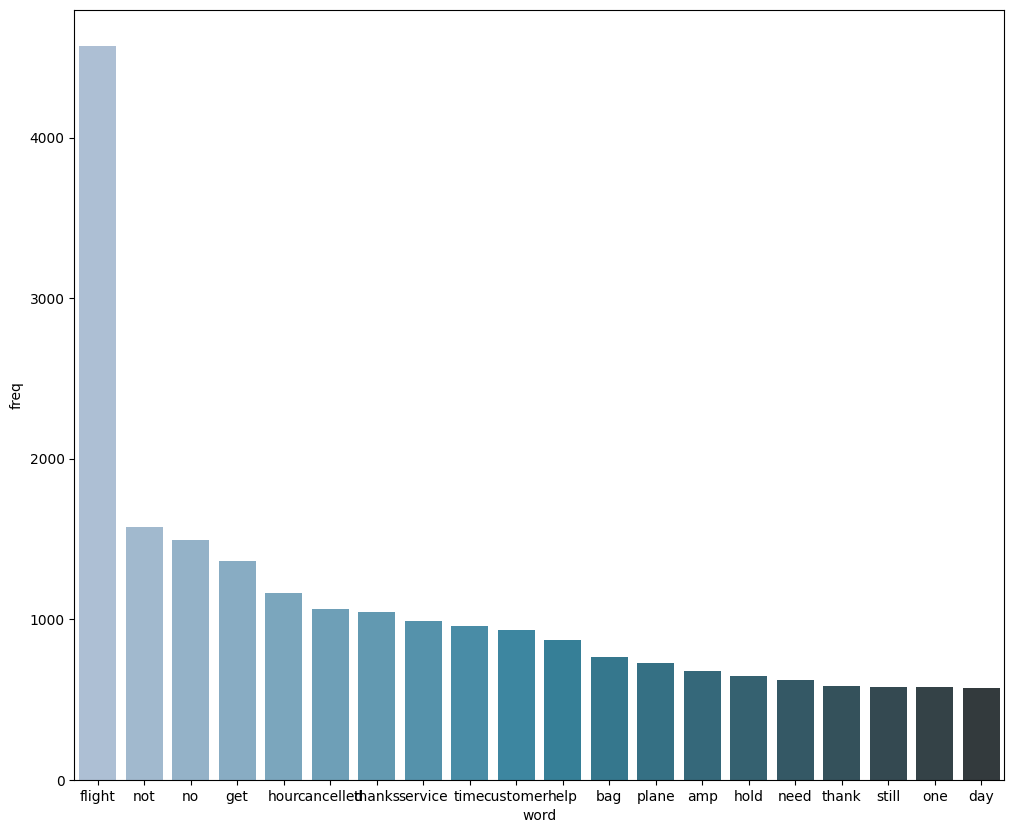

In [115]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)

# Use get_feature_names_out instead of get_feature_names
word_freq = dict(zip(cv.get_feature_names_out(), np.asarray(bow.sum(axis=0)).ravel()))

word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns=['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show()

In [116]:
# Exemple de texte avant nettoyage
original_text = df['text'].iloc[1]
print("Original Text:", original_text)

# Exemple de texte après nettoyage (après suppression des stopwords)
cleaned_text = sr_clean.iloc[1]
print("Cleaned Text:", cleaned_text)

Original Text: @VirginAmerica I didn't today... Must mean I need to take another trip!
Cleaned Text: today must mean need take another trip


In [117]:
df_model = df
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['text', 'airline_sentiment', 'language', 'clean_text']

In [118]:
df_model[df_model.duplicated()]

,text,airline_sentiment,language,clean_text
331,@VirginAmerica Thanks!,positive,en,thanks
515,@united thanks,positive,en,thanks
1477,@united thank you!,positive,en,thank
1938,@united thank you,positive,en,thank
1969,@united thank you!,positive,en,thank
...,...,...,...,...
13995,@AmericanAir 800 number will not even let you...,negative,en,number not even let wait next customer rep fru...
14386,@AmericanAir I want to speak to a human being!...,negative,en,want speak human not obscene request
14392,@AmericanAir no response to DM or email yet. ...,negative,en,no response dm email yet customer service
14543,@AmericanAir should reconsider #usairways acqu...,negative,en,reconsider usairways acquisition flight aa gol...


In [119]:
df_model = df_model.drop_duplicates()

In [120]:
df_model.isnull().sum()

,0
text,0
airline_sentiment,0
language,0
clean_text,21


In [121]:
# Supprimer les lignes où 'clean_text' contient des valeurs nulles
df_model = df_model[df_model['clean_text'].notna()]

# Vérifier à nouveau les valeurs nulles
print(df_model.isnull().sum())

text                 0
airline_sentiment    0
language             0
clean_text           0
dtype: int64


In [122]:
df_model.shape

(14201, 4)

In [123]:
# Conserver uniquement les colonnes nécessaires
colonnes = ['airline_sentiment', 'clean_text']
df_model = df[colonnes]
df_model.columns.tolist()

['airline_sentiment', 'clean_text']

**Encodage des données**

In [125]:
y=df_model["airline_sentiment"]

In [126]:
sentiment_ordering= ['negative','positive','neutral']
y= y.apply(lambda x: sentiment_ordering.index(x))

**Vectorisation des données**

1.   Avec **CountVectorizer (Sac de mots BoW)**

In [152]:
from sklearn.feature_extraction.text import CountVectorizer

# Remplacer les NaN par une chaîne vide
df_model['clean_text'] = df_model['clean_text'].fillna('')

# Appliquer la vectorisation
cv = CountVectorizer(max_features=3000)
X_fin = cv.fit_transform(df_model['clean_text']).toarray()

# Afficher la forme de la matrice
print(X_fin.shape)

<ipython-input-152-543f2b3d836b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['clean_text'] = df_model['clean_text'].fillna('')


(14404, 3000)


**Division d'ensemble de données**

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_fin,y,test_size=0.2)

**Application des modeles ML**

In [129]:
from sklearn.ensemble import RandomForestClassifier

# Initialisation du modèle RandomForest
model1 = RandomForestClassifier(random_state=42)
# Entraînement du modèle
model1.fit(X_train, y_train)
# Prédictions sur les données de test
y_pred1 = model1.predict(X_test)
# Calcul de l'accuracy
accuracy_rf = accuracy_score(y_test, y_pred1)
print("Test accuracy:", accuracy_rf)
cf_rf=classification_report(y_test,y_pred1)
print(cf_rf)

Test accuracy: 0.7743838944810829
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1832
           1       0.70      0.66      0.68       456
           2       0.62      0.45      0.52       593

    accuracy                           0.77      2881
   macro avg       0.71      0.67      0.69      2881
weighted avg       0.76      0.77      0.76      2881



In [130]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Initialiser et entraîner le modèle Naive Bayes
model2 = MultinomialNB()
model2.fit(X_train, y_train)

# Faire des prédictions
y_pred2 = model2.predict(X_test)

# Calculer l'accuracy
accuracy_NB = accuracy_score(y_test, y_pred2)
print("Test Accuracy:", accuracy_NB)

# Afficher le rapport de classification
cf_NB = classification_report(y_test, y_pred2)
print(cf_NB)

Test Accuracy: 0.7827143353002429
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1832
           1       0.72      0.74      0.73       456
           2       0.62      0.49      0.55       593

    accuracy                           0.78      2881
   macro avg       0.73      0.71      0.71      2881
weighted avg       0.77      0.78      0.78      2881

Accuracy of loaded model: 0.7827143353002429


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy: 0.801457827143353
F1-score: 0.7979197260279967
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1866
           1       0.79      0.68      0.73       463
           2       0.61      0.57      0.59       552

    accuracy                           0.80      2881
   macro avg       0.75      0.72      0.73      2881
weighted avg       0.80      0.80      0.80      2881

Matrice de confusion :
[[1681   42  143]
 [  89  316   58]
 [ 197   43  312]]


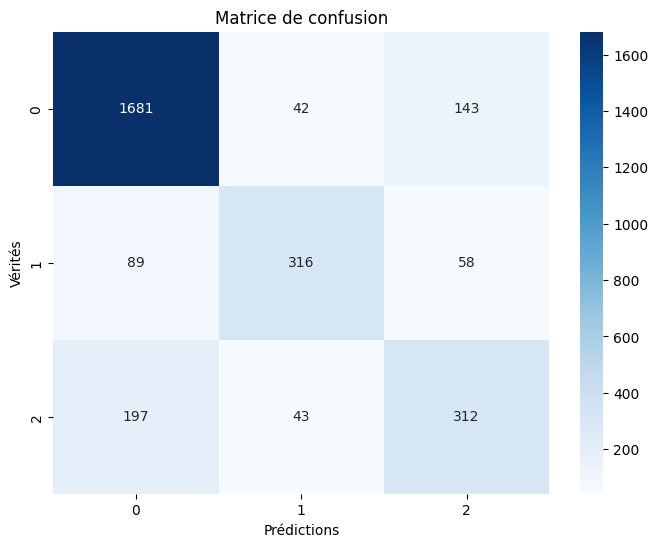

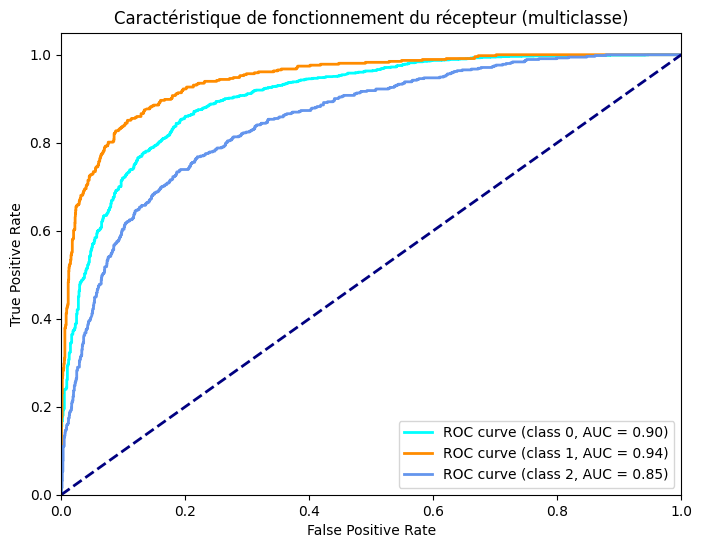

In [162]:
# Initialiser et entraîner le modèle Logistic Regression
model3 = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
model3.fit(X_train, y_train)

# Faire des prédictions
y_pred3 = model3.predict(X_test)

# Calculer l'accuracy
accuracy_LR = accuracy_score(y_test, y_pred3)
print("Test Accuracy:", accuracy_LR)

# Calculer le F1-score
f1_LR = f1_score(y_test, y_pred3, average='weighted')  # Utiliser average='weighted' pour les classes déséquilibrées
print("F1-score:", f1_LR)

# Afficher le rapport de classification
cf_LR = classification_report(y_test, y_pred3)
print(cf_LR)

# Calculer et afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred3)
print("Matrice de confusion :")
print(conf_matrix)

# Utiliser seaborn pour afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()

# Binariser les labels pour la courbe ROC (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_prob3 = model3.predict_proba(X_test)

# Calculer la courbe ROC et AUC pour chaque classe
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob3[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Afficher la courbe ROC pour chaque classe
plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue']  # Ajouter plus de couleurs si vous avez plus de classes
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2, label=f'ROC curve (class {i}, AUC = {roc_auc[i]:.2f})')

# Courbe de base
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Caractéristique de fonctionnement du récepteur (multiclasse)')

plt.legend(loc='lower right')

plt.show()

In [132]:
# Initialisation du modèle SVM
model_svm = SVC(random_state=42)

# Entraînement du modèle
model_svm.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred_svm = model_svm.predict(X_test)

# Calcul de l'accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy of SVM model:", accuracy_svm)

# Rapport de classification
cf_SVM = classification_report(y_test, y_pred_svm)
print(cf_SVM)

Accuracy of SVM model: 0.7969455050329747
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1832
           1       0.79      0.63      0.70       456
           2       0.67      0.50      0.57       593

    accuracy                           0.80      2881
   macro avg       0.76      0.69      0.72      2881
weighted avg       0.79      0.80      0.79      2881

Accuracy of loaded model: 0.7969455050329747


2.   Avec **TF-idf**

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Remplacer les NaN par une chaîne vide
df_model['clean_text'] = df_model['clean_text'].fillna('')

# Appliquer la vectorisation avec TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
X_fin_tfidf = tfidf.fit_transform(df_model['clean_text']).toarray()

# Afficher la forme de la matrice
print(X_fin_tfidf.shape)

<ipython-input-133-c150e42b13c5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['clean_text'] = df_model['clean_text'].fillna('')


(14404, 3000)


In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_fin_tfidf,y,test_size=0.2)

In [135]:
from sklearn.ensemble import RandomForestClassifier
# Initialisation du modèle RandomForest
model1 = RandomForestClassifier(random_state=42)
# Entraînement du modèle
model1.fit(X_train, y_train)
# Prédictions sur les données de test
y_pred1 = model1.predict(X_test)
# Calcul de l'accuracy
accuracy_rf = accuracy_score(y_test, y_pred1)
print("Test accuracy:", accuracy_rf)
cf_rf=classification_report(y_test,y_pred1)
print(cf_rf)

Test accuracy: 0.7646650468587296
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      1848
           1       0.76      0.53      0.62       476
           2       0.61      0.45      0.52       557

    accuracy                           0.76      2881
   macro avg       0.72      0.63      0.67      2881
weighted avg       0.75      0.76      0.75      2881

0.7646650468587296


In [136]:
# Initialisation du modèle LogisticRegression
model3 = LogisticRegression(random_state=42)

# Entraînement du modèle
model3.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred3 = model3.predict(X_test)

# Calcul de l'accuracy
accuracy_LR = accuracy_score(y_test, y_pred3)
print("Test Accuracy:", accuracy_LR)

# Rapport de classification
cf_LR = classification_report(y_test, y_pred3)
print(cf_LR)

Test Accuracy: 0.7906976744186046
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1848
           1       0.83      0.58      0.68       476
           2       0.62      0.51      0.56       557

    accuracy                           0.79      2881
   macro avg       0.76      0.67      0.71      2881
weighted avg       0.78      0.79      0.78      2881

0.7906976744186046


In [137]:
from sklearn.naive_bayes import MultinomialNB

# Initialisation du modèle MultinomialNB
model2 = MultinomialNB()

# Entraînement du modèle
model2.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred2 = model2.predict(X_test)

# Calcul de l'accuracy
accuracy_NB = accuracy_score(y_test, y_pred2)
print("Test Accuracy:", accuracy_NB)

# Rapport de classification
cf_NB = classification_report(y_test, y_pred2)
print(cf_NB)

Test Accuracy: 0.7466157584172163
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1848
           1       0.86      0.39      0.54       476
           2       0.67      0.30      0.42       557

    accuracy                           0.75      2881
   macro avg       0.76      0.55      0.60      2881
weighted avg       0.75      0.75      0.71      2881

0.7466157584172163


In [138]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Initialisation du modèle SVM
model_svm = SVC(random_state=42)

# Entraînement du modèle
model_svm.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred_svm = model_svm.predict(X_test)

# Calcul de l'accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy of SVM model:", accuracy_svm)

# Rapport de classification
cf_SVM = classification_report(y_test, y_pred_svm)
print(cf_SVM)

Accuracy of SVM model: 0.794168691426588
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      1848
           1       0.85      0.58      0.69       476
           2       0.67      0.45      0.54       557

    accuracy                           0.79      2881
   macro avg       0.78      0.66      0.70      2881
weighted avg       0.79      0.79      0.78      2881

0.794168691426588


3.   Avec **ngram**

In [139]:
# Remplacer les NaN par une chaîne vide
df_model['clean_text'] = df_model['clean_text'].fillna('')

# Appliquer la vectorisation avec n-grams
ngram_vectorizer = CountVectorizer(max_features=3000, ngram_range=(1, 2))  # n-grams de taille 1 (unigram) à 2 (bigram)
X_ngram = ngram_vectorizer.fit_transform(df_model['clean_text']).toarray()

# Afficher la forme de la matrice
print(X_ngram.shape)

# Afficher quelques n-grams
print("Features (n-grams):", ngram_vectorizer.get_feature_names_out()[:20])  # Affiche les 20 premiers n-grams

<ipython-input-139-7db027d5e8e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['clean_text'] = df_model['clean_text'].fillna('')


(14404, 3000)
Features (n-grams): ['aa' 'aa flight' 'aadvantage' 'abc' 'ability' 'able' 'able get' 'abq'
 'absolute' 'absolutely' 'absurd' 'accept' 'acceptable' 'accepted'
 'accepting' 'access' 'accommodate' 'accommodation' 'according' 'account']


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_ngram, y, test_size=0.2, random_state=42)

In [141]:
from sklearn.ensemble import RandomForestClassifier
# Initialisation du modèle RandomForest
model1 = RandomForestClassifier(random_state=42)
# Entraînement du modèle
model1.fit(X_train, y_train)
# Prédictions sur les données de test
y_pred1 = model1.predict(X_test)
# Calcul de l'accuracy
accuracy_rf = accuracy_score(y_test, y_pred1)
print("Test accuracy:", accuracy_rf)
cf_rf=classification_report(y_test,y_pred1)
print(cf_rf)

Test accuracy: 0.7726483859770913
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1866
           1       0.71      0.64      0.67       463
           2       0.58      0.48      0.52       552

    accuracy                           0.77      2881
   macro avg       0.71      0.67      0.69      2881
weighted avg       0.76      0.77      0.77      2881



In [142]:
model3 = LogisticRegression()
model3.fit(X_train, y_train)
y_pred3=model3.predict(X_test)
y_pred3
accuracy_LR = accuracy_score(y_test, y_pred3)
print("Test Accuracy:", accuracy_LR)
cf_LR=classification_report(y_test,y_pred3)
print(cf_LR)

Test Accuracy: 0.7979868101353697
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1866
           1       0.78      0.70      0.74       463
           2       0.58      0.58      0.58       552

    accuracy                           0.80      2881
   macro avg       0.74      0.72      0.73      2881
weighted avg       0.80      0.80      0.80      2881



In [79]:
from sklearn.svm import SVC
# Initialisation du modèle SVM
model_svm = SVC(random_state=42)

# Entraînement du modèle
model_svm.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred_svm = model_svm.predict(X_test)

# Calcul de l'accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy of SVM model:", accuracy_svm)
cf_SVM=classification_report(y_test,y_pred_svm)
print(cf_SVM)

Accuracy of SVM model: 0.792086081221798
              precision    recall  f1-score   support

           0       0.83      0.93      0.87      1866
           1       0.82      0.59      0.69       463
           2       0.61      0.51      0.56       552

    accuracy                           0.79      2881
   macro avg       0.75      0.68      0.71      2881
weighted avg       0.78      0.79      0.78      2881



In [143]:
model2= MultinomialNB()
model2.fit(X_train, y_train)
y_pred2=model2.predict(X_test)
y_pred2
accuracy_NB = accuracy_score(y_test, y_pred2)
print("Test Accuracy:", accuracy_NB)
cf_NB=classification_report(y_test,y_pred2)
print(cf_NB)

Test Accuracy: 0.7698715723707046
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1866
           1       0.71      0.70      0.71       463
           2       0.55      0.52      0.53       552

    accuracy                           0.77      2881
   macro avg       0.70      0.69      0.70      2881
weighted avg       0.77      0.77      0.77      2881



In [144]:
y=df_model["airline_sentiment"]
sentiment_ordering= ['negative','positive','neutral']
y= y.apply(lambda x: sentiment_ordering.index(x))

**Application modele DL**

In [165]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Paramètres du tokenizer
vocabulary_size = 4000
max_text_len = 50

# Remplacer les NaN par des chaînes vides et s'assurer que toutes les valeurs sont des chaînes de caractères
df_model['clean_text'] = df_model['clean_text'].fillna('').astype(str)

# Tokenisation des textes
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(df_model['clean_text'].values)
sequences = tokenizer.texts_to_sequences(df_model['clean_text'].values)

# Padding des séquences
X_DeepLearning = pad_sequences(sequences, maxlen=max_text_len)

# Définir les labels (ici, 'airline_sentiment' est la colonne des étiquettes)
labels = df_model['airline_sentiment'].values
'''
# Division des données en ensembles d'entraînement et de test
XX_train, XX_test, y_train, y_test = train_test_split(X_DeepLearning, labels, test_size=0.20, random_state=42)

# Affichage des dimensions des données d'entraînement et de test
print(XX_train.shape, y_train.shape, XX_test.shape, y_test.shape)'''

<ipython-input-165-9ae3bdcf62db>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['clean_text'] = df_model['clean_text'].fillna('').astype(str)


"\n# Division des données en ensembles d'entraînement et de test\nXX_train, XX_test, y_train, y_test = train_test_split(X_DeepLearning, labels, test_size=0.20, random_state=42)\n\n# Affichage des dimensions des données d'entraînement et de test\nprint(XX_train.shape, y_train.shape, XX_test.shape, y_test.shape)"

In [166]:
# Division des données en ensembles d'entraînement et de test avec stratification
XX_train, XX_test, y_train_classes, y_test_classes = train_test_split(
    X_DeepLearning, df['airline_sentiment'].values,
    test_size=0.2, random_state=42, stratify=df['airline_sentiment'].values)

# Conversion des étiquettes en valeurs numériques
airline_sentiment = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_classes = pd.Series(y_train_classes).map(airline_sentiment)
y_test_classes = pd.Series(y_test_classes).map(airline_sentiment)

# Vérifier que les labels ont été correctement convertis en entiers
print(y_train_classes.head())
print(y_test_classes.head())

# Calcul des poids de classe
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)

# Conversion en dictionnaire pour Keras
class_weights = dict(enumerate(class_weights))

# Affichage des poids
print("Poids de classe calculés :", class_weights)

0    0
1    0
2    2
3    0
4    2
dtype: int64
0    0
1    0
2    0
3    0
4    0
dtype: int64
Poids de classe calculés : {0: 0.5267416346681295, 1: 1.6024196912807676, 2: 2.09432933478735}


In [167]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Hyperparamètres
embedding_dim = 100
vocabulary_size = 5000
max_text_len = 100
filters = 64
kernel_size = 3

# Initialisation du modèle
model = Sequential()

# Couche d'embedding
model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_text_len))

# Couche convolutionnelle + pooling
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Couche LSTM
model.add(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))

# Couche dense avec régularisation
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Couche de sortie
model.add(Dense(3, activation='softmax'))

# Compilation avec RMSprop
optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks pour early stopping et réduction du learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Entraînement
history = model.fit(
    XX_train,
    y_train_classes,
    epochs=30,
    batch_size=64,
    validation_data=(XX_test, y_test_classes),
    class_weight=class_weights,
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


181/181 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.5687 - loss: 1.9366 - val_accuracy: 0.2812 - val_loss: 1.4818 - learning_rate: 5.0000e-04
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.7530 - loss: 0.9384 - val_accuracy: 0.7508 - val_loss: 0.8934 - learning_rate: 5.0000e-04
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.8115 - loss: 0.6371 - val_accuracy: 0.6890 - val_loss: 0.7762 - learning_rate: 5.0000e-04
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.8500 - loss: 0.4695 - val_accuracy: 0.6595 - val_loss: 0.8949 - learning_rate: 5.0000e-04
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.8776 - loss: 0.3818 - val_accuracy: 0.6921 - val_loss: 0.8917 - learning_rate: 5.0000e-04
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.8954 - loss: 0.3241 - val_accuracy: 0.7636 - val_loss: 0.7078 - learning_rate: 5.0000e-04
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accurac

In [168]:
import tensorflow as tf
# Entraîner le modèle
history = model.fit(
    XX_train,
    y_train_classes,
    epochs=5,
    batch_size=32,
    validation_data=(XX_test, y_test_classes),
    class_weight=class_weights
)

# Évaluer le modèle sur les données de test
test_loss, test_accuracy = model.evaluate(XX_test, y_test_classes, batch_size=32)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.9194 - loss: 0.2617 - val_accuracy: 0.7584 - val_loss: 0.7950
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9301 - loss: 0.2269 - val_accuracy: 0.7626 - val_loss: 0.7673
Epoch 3/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 43s 64ms/step - accuracy: 0.9400 - loss: 0.2075 - val_accuracy: 0.7661 - val_loss: 0.8058
Epoch 4/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9439 - loss: 0.1860 - val_accuracy: 0.6966 - val_loss: 1.0902
Epoch 5/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9496 - loss: 0.1754 - val_accuracy: 0.7699 - val_loss: 0.8706
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7705 - loss: 0.8691
Test Accuracy: 76.99%
